In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('results/trans_results.csv')
perf_df = pd.read_csv('results/perfs.csv')

In [3]:
states = ["s", "d", "b", "f", "q"]
state_names = [s[0].upper() for s in states]

In [4]:
all_sessions = list(range(-4,19))
all_sessions.remove(0)
all_sessions

[-4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [5]:
def transition_matrix(transitions):
    trans_list = []
    n = 5

    for (i,j) in zip(transitions,transitions[1:]):
        mat = np.zeros((n,n))
        mat[i,j] = 1
        trans_list = np.append(trans_list, [mat.flatten()])

    M = sum(trans_list.reshape(int(len(trans_list)/(n**2)), n, n))
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M


In [6]:
def trans_wrapper(df, normalized=True):
    transitions = df['labels_h'].copy()
    
    sstates = set(transitions)
    i_t = set(df['labels'].copy())

    not_founds = list(set(range(0,5)) - i_t)

    ids = {k: 0 + i for i, k in enumerate(sstates)}
    transitions = transitions.map(ids)
    

    counts = transitions.value_counts().sort_index()
    frequencies = counts/counts.sum()

    transition = np.array(transition_matrix(transitions))
    f = np.array(frequencies)[None,:]
    f = np.insert(f, 0, not_founds)
    if(normalized):
        transition = transition/f

    return transition

In [7]:


session_mats = [trans_wrapper(df[df['session'].astype(int) == session]) for session in all_sessions]

everything_mat = trans_wrapper(df)

In [8]:
columns = []
[[columns.append(ii+jj) for ii in state_names] for jj in state_names]

export_mats_np = np.zeros((len(all_sessions),25))
s_num = 0
for s in session_mats:
    s = s.flatten()
    for ii in range(len(s)-1):
        export_mats_np[s_num,ii] = s[ii]
    s_num += 1
export_mats = pd.DataFrame(export_mats_np,columns=columns)
export_mats.to_csv("results/session_markovs.csv")

In [9]:
perfs = []
for s in all_sessions:
    if(s in perf_df["mission"].tolist()):
        p = [perf_df[perf_df['mission'] == s]['perf']][0].tolist()
        perfs = perfs + p
perfs = np.array(perfs)

In [10]:
corrs = np.zeros((len(states), len(states)))
pvals = np.zeros((len(states), len(states)))

In [11]:
markov_df = pd.DataFrame(columns=['from','to','corr','p-val'])
for i in range(0,len(state_names)):
    for j in range(0,len(state_names)):
        l = []
        for m in session_mats:
            try:
                l = l + [m[i][j]]
            except:
                l =l + [0]
        corr, pval = pearsonr(l,perfs)
        corrs[i][j] = corr
        pvals[i][j] = pval
        row = pd.DataFrame({
            "from": states[i],   "to": states[j],
            "corr": corr,       "p-val": pval
        }, index=[len(markov_df.index)])
        markov_df = pd.concat([markov_df, row], ignore_index=True)
markov_df

,from,to,corr,p-val
0,s,s,0.452598,0.034426
1,s,d,0.362273,0.097548
2,s,b,0.178966,0.425515
3,s,f,-0.290502,0.189676
4,s,q,-0.201399,0.368778
5,d,s,-0.110132,0.625620
6,d,d,0.205232,0.359542
7,d,b,0.174308,0.437854
8,d,f,-0.295472,0.181867
9,d,q,-0.225636,0.312664


In [12]:
sig_trans = pvals > 0.9
markov_df[(sig_trans).flatten()]

,from,to,corr,p-val
17,f,b,0.022797,0.919789


[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'corrs')]

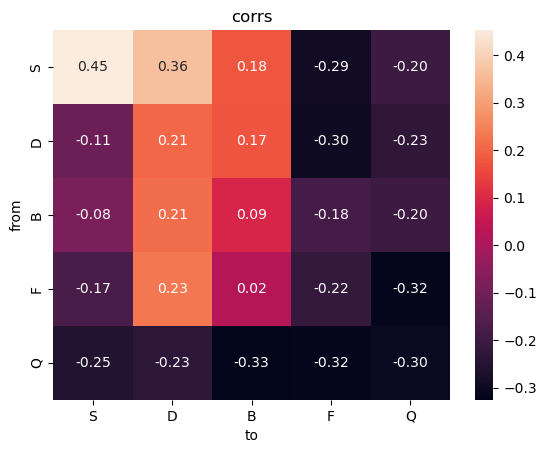

In [13]:
# corrs matrix
hm = sns.heatmap(corrs, fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title='corrs')

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'pvals')]

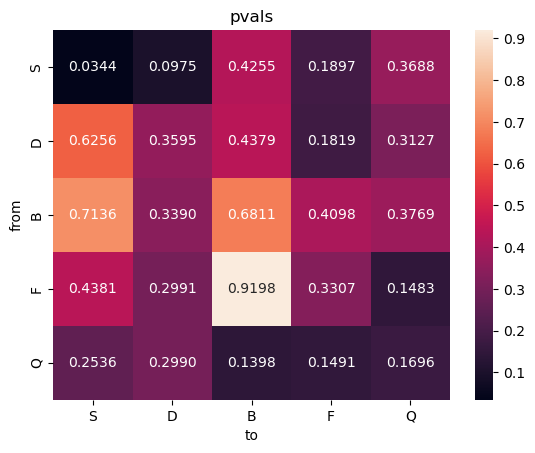

In [14]:
# corr p-vals
hm = sns.heatmap(pvals, fmt='.4f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title="pvals")

In [15]:
high_perfs = [-3,-4,3,4,12,13,17]
low_perfs = [-1,-2,1,2,5,6,7,8,9,10,11,14,15,16]

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'high performance')]

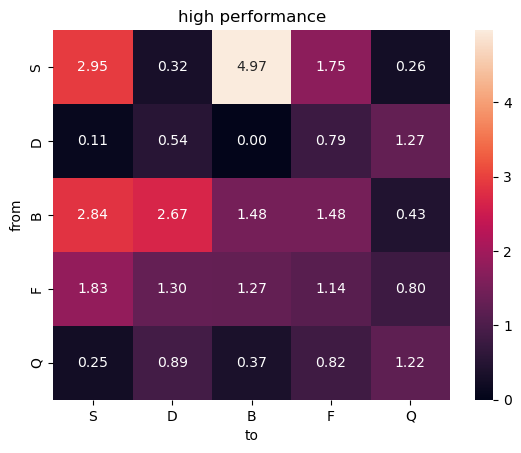

In [16]:
h_df = pd.DataFrame()
for s in high_perfs:
    h_df = pd.concat([df[df['session'] == s],h_df])

hm = sns.heatmap(trans_wrapper(h_df), fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title='high performance')

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'low performance')]

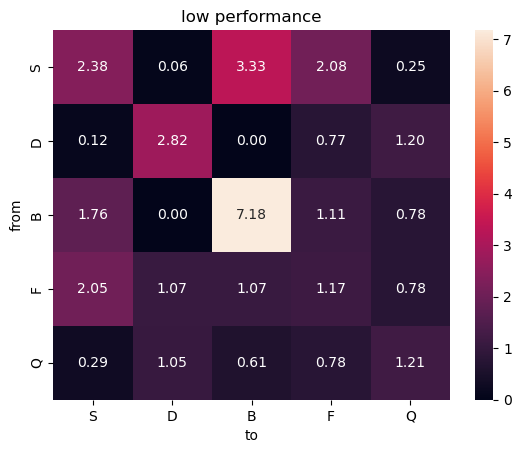

In [17]:
l_df = pd.DataFrame()
for s in low_perfs:
    l_df = pd.concat([df[df['session'] == s],l_df])

lm = sns.heatmap(trans_wrapper(l_df), fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
lm.set(ylabel='from', xlabel='to',title='low performance')

heatmaps(nek21_trans_df['labels_h'].copy(), title="trans")